3. Take selfies and do key point detection using above code. Describe the results you see. You should try multiple angles. (5 pts)

In [14]:
import numpy as np
from scipy.ndimage import gaussian_filter
import time
import matplotlib.pyplot as plt

class SIFT_Keypoint_Detector:
    def __init__(self, nfeatures=0, nLayersinOctave=3, contrastThreshold=0.01, 
                 edgeThreshold=10, sigma=1.6):
        self.nfeatures = nfeatures
        self.nLayersinOctave = nLayersinOctave
        self.contrastThreshold = contrastThreshold
        self.edgeThreshold = edgeThreshold
        self.sigma = sigma
        self.SIFT_FIXPT_SCALE = 1

    def create_initial_image(self, img, double_image_size=False):
        if len(img.shape) == 3:
            gray = np.dot(img[..., :3], [0.299, 0.587, 0.114])
        else:
            gray = img
        gray_float = gray.astype(np.float32) * self.SIFT_FIXPT_SCALE
        sig_diff = np.sqrt(max(self.sigma**2 - (1.6**2 * 4), 0.01))
        
        if double_image_size:
            gray_float = np.repeat(np.repeat(gray_float, 2, axis=0), 2, axis=1)
        
        return gaussian_filter(gray_float, sig_diff)

    def build_Gaussian_Pyramid(self, base, nOctaves):
        k = 2**(1. / self.nLayersinOctave)
        sigma = np.array([k**i * self.sigma for i in range(self.nLayersinOctave + 3)])
        sigma_diff = np.sqrt(np.diff(sigma**2))

        pyramid = []
        for o in range(nOctaves):
            octave = [base] if o == 0 else [pyramid[-1][-3][::2, ::2]]
            for i in range(1, self.nLayersinOctave + 3):
                octave.append(gaussian_filter(octave[-1], sigma_diff[i-1]))
            pyramid.append(octave)
            base = octave[-3][::2, ::2]
        return pyramid

    def build_DoG_Pyramid(self, Gaussian_Pyramid, nOctaves):
        return [[octave[i+1] - octave[i] for i in range(len(octave) - 1)]
                for octave in Gaussian_Pyramid]

    def find_scale_space_extrema(self, DoG_pyramid):
        threshold = float(0.5 * self.contrastThreshold / self.nLayersinOctave * 255 * self.SIFT_FIXPT_SCALE)
        keypoints = []

        for o, octave in enumerate(DoG_pyramid):
            for i in range(1, len(octave) - 1):
                prev, curr, next = octave[i-1:i+2]
                
                # using sliding_window_view from numpy here for efficiency
                window = np.lib.stride_tricks.sliding_window_view(curr, (3, 3))
                center = window[:, :, 1, 1]
                neighbors = np.dstack([window[:, :, i, j] for i in range(3) for j in range(3) if (i != 1 or j != 1)])
                
                # check for the local extrema in the 3x3x3 neighborhood
                is_max = (np.abs(center) > threshold) & (center > 0) & \
                        (center > neighbors.max(axis=2)) & \
                        (center > prev[1:-1, 1:-1]) & (center > next[1:-1, 1:-1])
                is_min = (np.abs(center) > threshold) & (center < 0) & \
                        (center < neighbors.min(axis=2)) & \
                        (center < prev[1:-1, 1:-1]) & (center < next[1:-1, 1:-1])
                
                extrema = is_max | is_min
                
                # edge response elimination
                dy = curr[1:-1, 2:] - curr[1:-1, :-2]
                dx = curr[2:, 1:-1] - curr[:-2, 1:-1]
                dxx = curr[1:-1, 2:] + curr[1:-1, :-2] - 2 * curr[1:-1, 1:-1]
                dyy = curr[2:, 1:-1] + curr[:-2, 1:-1] - 2 * curr[1:-1, 1:-1]
                dxy = ((curr[2:, 2:] + curr[:-2, :-2]) - (curr[2:, :-2] + curr[:-2, 2:])) / 4
                tr = dxx + dyy
                det = dxx * dyy - dxy ** 2
                edge_response = (tr ** 2) / det
                extrema = extrema & (edge_response < (self.edgeThreshold + 1) ** 2 / self.edgeThreshold)
                
                y, x = np.where(extrema)
                keypoints.extend([(o, i, r+1, c+1) for r, c in zip(y, x)])

        return keypoints

    def detect_keypoints(self, img):
        base = self.create_initial_image(img)
        nOctaves = int(round(np.log(min(base.shape)) / np.log(2) - 2))
        gpyr = self.build_Gaussian_Pyramid(base, nOctaves)
        dogpyr = self.build_DoG_Pyramid(gpyr, nOctaves)
        keypoints = self.find_scale_space_extrema(dogpyr)
        
        if self.nfeatures > 0 and len(keypoints) > self.nfeatures:
            keypoints = keypoints[:self.nfeatures]
        
        return keypoints
    
    def draw_keypoints(self, gray_img, keypoints, markersize=2):
        plt.imshow(gray_img, cmap='gray')
        height, width = gray_img.shape[:2]
        keypoints_array = np.array(keypoints)
        
        # Vectorized scaling of keypoint coordinates
        scales = 2 ** keypoints_array[:, 0]
        y_scaled = keypoints_array[:, 2] * scales
        x_scaled = keypoints_array[:, 3] * scales
        
        plt.plot(x_scaled, y_scaled, 'ro', markersize=markersize)
        plt.title('Manual Keypoint Detection')
        plt.show()

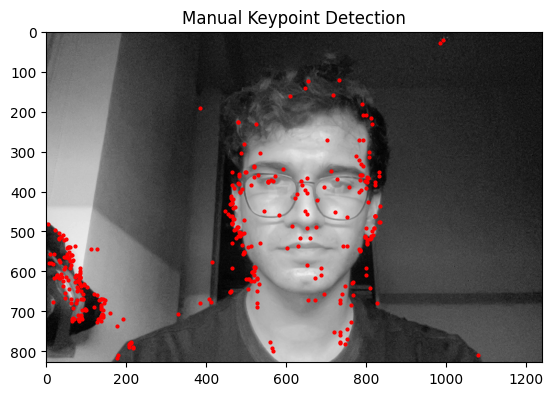

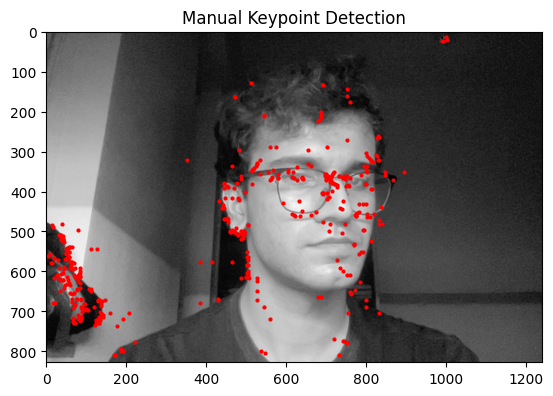

/var/folders/vg/c0z21yg92qd0jhn0p09c9x200000gp/T/ipykernel_23290/1119322318.py:78: RuntimeWarning: divide by zero encountered in divide
  edge_response = (tr ** 2) / det


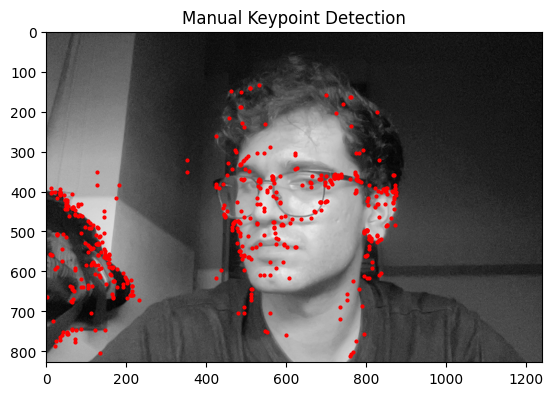

In [18]:
import cv2

img_1 = cv2.imread('3_images/selfie1.jpg')
img_2 = cv2.imread('3_images/selfie2.jpg')
img_3 = cv2.imread('3_images/selfie3.jpg')

gray_img1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2GRAY)
gray_img2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2GRAY)
gray_img3 = cv2.cvtColor(img_3, cv2.COLOR_BGR2GRAY)

sift_detector = SIFT_Keypoint_Detector(nfeatures=0, nLayersinOctave=3, contrastThreshold=0.13, edgeThreshold=10, sigma=1.6)

keypoints1 = sift_detector.detect_keypoints(gray_img1)
sift_detector.draw_keypoints(gray_img1, keypoints1)

keypoints2 = sift_detector.detect_keypoints(gray_img2)
sift_detector.draw_keypoints(gray_img2, keypoints2)

keypoints3 = sift_detector.detect_keypoints(gray_img3)
sift_detector.draw_keypoints(gray_img3, keypoints3)

### Results:

1. Constant places where keypoints are being marked.
2. Which locations are these.
3. 